In [1]:

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier

In [2]:
df = pd.read_csv('../input/wiki_movie_plots_deduped.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


# EDA

# 1. to check for no of values

In [3]:
df['Genre'].describe()


count       34886
unique       2265
top       unknown
freq         6083
Name: Genre, dtype: object

In [4]:
# grouping based on genre to see what genre is present in the df
df.groupby(['Genre']).count().sort_values('Title',ascending=False)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Wiki Page,Plot
Genre,,,,,,,
unknown,6083,6083,6083,6083,5400,6083,6083
drama,5964,5964,5964,5964,5841,5964,5964
comedy,4379,4379,4379,4379,4347,4379,4379
horror,1167,1167,1167,1167,1124,1167,1167
action,1098,1098,1098,1098,1087,1098,1098
thriller,966,966,966,966,955,966,966
romance,923,923,923,923,918,923,923
western,865,865,865,865,864,865,865
crime,568,568,568,568,565,568,568


### There are 2265 genres in this df. so narrowing it down to 10 main genres 
### https://www.filmsite.org/genres.html
### Action, adventure, crime, comedy, drama, epic/historical, horror, musical/dance, scifi, war, western, thriller, romance -  is this okay ??????

# Text - preprocessing 

In [5]:
df['Count']=1
df[['Genre','Count']].groupby(['Genre'], as_index=False).count().shape[0]

2265

In [6]:
# harmonization
df['Cleaned_genre'] =df['Genre'] 
df['Cleaned_genre']=df['Cleaned_genre'].str.strip()
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' - ', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' / ', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('/', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' & ', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(', ', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('; ', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('bio-pic', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biopic', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biographical', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biodrama', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('bio-drama', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biographic', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(film genre\)', '')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('animated','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('anime','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('children\'s','children')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedey','comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\[not in citation given\]','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' set 4,000 years ago in the canadian arctic','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('historical','history')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romantic','romance')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('3-d','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('3d','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('viacom 18 motion pictures','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('sci-fi','science_fiction')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('ttriller','thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('.','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('based on radio serial','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' on the early years of hitler','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('sci fi','science_fiction')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('science fiction','science_fiction')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' (30min)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('16 mm film','short')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\[140\]','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\[144\]','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' for ','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('adventures','adventure')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('kung fu','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('kung-fu','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('martial arts','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('world war ii','war')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('world war i','war')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biography about montreal canadiens star|maurice richard','biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('bholenath df|cinekorn entertainment','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(volleyball\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('spy film','spy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('anthology film','anthology')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biography fim','biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('avant-garde','avant_garde')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biker film','biker')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('buddy cop','buddy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('buddy film','buddy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedy 2-reeler','comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('films','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('film','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biography of pioneering american photographer eadweard muybridge','biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('british-german co-production','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('bruceploitation','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy-drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('df by the mob\|knkspl','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('df','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('movie','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('coming of age','coming_of_age')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('coming-of-age','coming_of_age')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('drama about child soldiers','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('(( based).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('(( co-produced).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('(( adapted).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('(( about).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('musical b','musical')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('animationchildren','animation|children')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' period','period')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('drama loosely','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(aquatics|swimming\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(aquatics|swimming\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace("yogesh dattatraya gosavi's directorial debut \[9\]",'')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace("war-time","war")
df['Cleaned_genre']=df['Cleaned_genre'].str.replace("wartime","war")
df['Cleaned_genre']=df['Cleaned_genre'].str.replace("ww1","war")
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('unknown','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace("wwii","war")
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('psychological','psycho')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('rom-coms','romance')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('true crime','crime')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|007','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('slice of life','slice_of_life')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('computer animation','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('gun fu','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('j-horror','horror')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(shogi|chess\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('afghan war drama','war drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|6 separate stories','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(30min\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' (road bicycle racing)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' v-cinema','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('tv miniseries','tv_miniseries')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|docudrama','\|documentary|drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' in animation','|animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('((adaptation).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('((adaptated).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('((adapted).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('(( on ).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('american football','sports')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dev\|nusrat jahan','sports')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('television miniseries','tv_miniseries')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(artistic\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \|direct-to-dvd','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('history dram','history drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('martial art','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('psycho thriller,','psycho thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|1 girl\|3 suitors','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(road bicycle racing\)','')
filterE = df['Cleaned_genre']=="ero"
df.loc[filterE,'Cleaned_genre']="adult"
filterE = df['Cleaned_genre']=="music"
df.loc[filterE,'Cleaned_genre']="musical"
filterE = df['Cleaned_genre']=="-"
df.loc[filterE,'Cleaned_genre']=''
filterE = df['Cleaned_genre']=="comedy–drama"
df.loc[filterE,'Cleaned_genre'] = "comedy|drama"
filterE = df['Cleaned_genre']=="comedy–horror"
df.loc[filterE,'Cleaned_genre'] = "comedy|horror"
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' ','|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(',','|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('-','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionadventure','action|adventure')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actioncomedy','action|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actiondrama','action|drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionlove','action|love')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionmasala','action|masala')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionchildren','action|children')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('fantasychildren\|','fantasy|children')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('fantasycomedy','fantasy|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('fantasyperiod','fantasy|period')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('cbctv_miniseries','tv_miniseries')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramacomedy','drama|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramacomedysocial','drama|comedy|social')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramathriller','drama|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedydrama','comedy|drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramathriller','drama|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedyhorror','comedy|horror')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('sciencefiction','science_fiction')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('adventurecomedy','adventure|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('animationdrama','animation|drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|\|','|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('muslim','religious')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('thriler','thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('crimethriller','crime|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('fantay','fantasy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionthriller','action|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedysocial','comedy|social')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('martialarts','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|\(children\|poker\|karuta\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('epichistory','epic|history')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('erotica','adult')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('erotic','adult')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('((\|produced\|).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('chanbara','chambara')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedythriller','comedy|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biblical','religious')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biblical','religious')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('colour\|yellow\|productions\|eros\|international','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|directtodvd','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('liveaction','live|action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('melodrama','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('superheroes','superheroe')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('gangsterthriller','gangster|thriller')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('heistcomedy','comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('heist','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('historic','history')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('historydisaster','history|disaster')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('warcomedy','war|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('westerncomedy','western|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('ancientcostume','costume')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('computeranimation','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramatic','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('familya','family')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('familya','family')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramedy','drama|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramaa','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('famil\|','family')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('superheroe','superhero')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biogtaphy','biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('devotionalbiography','devotional|biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('docufiction','documentary|fiction')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('familydrama','family|drama')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('espionage','spy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('supeheroes','superhero')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romancefiction','romance|fiction')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('horrorthriller','horror|thriller')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('suspensethriller','suspense|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('musicaliography','musical|biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('triller','thriller')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|\(fiction\)','|fiction')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romanceaction','romance|action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romancecomedy','romance|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romancehorror','romance|horror')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romcom','romance|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('rom\|com','romance|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('satirical','satire')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('science_fictionchildren','science_fiction|children')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('homosexual','adult')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('sexual','adult')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('mockumentary','documentary')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('periodic','period')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romanctic','romantic')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('politics','political')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('samurai','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('tv_miniseries','series')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('serial','series')

filterE = df['Cleaned_genre']=="musical–comedy"
df.loc[filterE,'Cleaned_genre'] = "musical|comedy"

filterE = df['Cleaned_genre']=="roman|porno"
df.loc[filterE,'Cleaned_genre'] = "adult"


filterE = df['Cleaned_genre']=="action—masala"
df.loc[filterE,'Cleaned_genre'] = "action|masala"


filterE = df['Cleaned_genre']=="horror–thriller"
df.loc[filterE,'Cleaned_genre'] = "horror|thriller"

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('family','children')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('martial_arts','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('horror','thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('war','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('adventure','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('science_fiction','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('western','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('western','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('noir','black')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('spy','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('superhero','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('social','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('suspense','action')


filterE = df['Cleaned_genre']=="drama|romance|adult|children"
df.loc[filterE,'Cleaned_genre'] = "drama|romance|adult"

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|–\|','|')
df['Cleaned_genre']=df['Cleaned_genre'].str.strip(to_strip='\|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionner','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.strip()



In [7]:
moviesGenre = df[['Cleaned_genre','Count']].groupby(['Cleaned_genre']).count()
moviesGenre.to_csv('Cleaned_genre.csv',sep=',')

In [8]:
#after harmonization the genre reduced to 1201 
df[['Cleaned_genre','Count']].groupby(['Cleaned_genre'], as_index=False).count().shape[0]

1201

In [9]:
#Overall look at our genre 
df[['Cleaned_genre','Count']].groupby(['Cleaned_genre'],as_index=False).count().sort_values(['Count'], ascending=False).head(10)


,Cleaned_genre,Count
0,,6204
517,drama,6107
360,comedy,4411
2,action,3790
1113,thriller,2163
965,romance,954
203,animation,601
974,romance|comedy,577
448,crime,573
388,comedy|drama,560


In [10]:
df['GenreSplit']=df['Cleaned_genre'].str.split('|')
df['GenreSplit']= df['GenreSplit'].apply(np.sort).apply(np.unique)

In [11]:
df['GenreSplit']

0                            []
1                            []
2                            []
3                            []
4                            []
5                            []
6                      [action]
7                      [comedy]
8                            []
9                            []
10                      [short]
11       [action, crime, short]
12                      [short]
13                  [biography]
14                     [comedy]
15                     [comedy]
16                      [drama]
17                      [drama]
18                     [comedy]
19                     [action]
20                      [drama]
21                     [action]
22                      [drama]
23                      [drama]
24                      [drama]
25                           []
26                      [drama]
27                           []
28                           []
29                     [comedy]
                  ...          
34856   

In [12]:
# number of movies for each genres
genres_array = np.array([])

for i in range(0,df.shape[0]-1):
    genres_array = np.concatenate((genres_array, df['GenreSplit'][i]))
    
genres_array

array(['', '', '', ..., 'comedy', 'comedy', 'romance'], dtype='<U32')

In [13]:
genres = pd.DataFrame({'Genre':genres_array})

In [14]:
genres.head(10)

,Genre
0,
1,
2,
3,
4,
5,
6,action
7,comedy
8,
9,


In [15]:
# histogram for the genres 
genres['Count']=1
genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False).head(10)


,Genre,Count
117,drama,9487
86,comedy,7320
0,,6220
4,action,5952
428,thriller,3291
339,romance,2639
95,crime,1607
246,musical,951
16,animation,914
74,children,684


In [16]:
#identifying which genres to be selected
genres=genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False)

In [17]:
genres = genres[genres['Genre']!='']
genres


,Genre,Count
117,drama,9487
86,comedy,7320
4,action,5952
428,thriller,3291
339,romance,2639
95,crime,1607
246,musical,951
16,animation,914
74,children,684
132,fantasy,542


In [18]:
TotalCountGenres=sum(genres['Count'])
TotalCountGenres

37328

In [19]:
genres['Frequency'] = genres['Count']/TotalCountGenres

In [20]:
genres['CumulativeFrequency'] = genres['Frequency'].cumsum()

In [21]:
genres.head(20)

,Genre,Count,Frequency,CumulativeFrequency
117,drama,9487,0.254152,0.254152
86,comedy,7320,0.196099,0.450252
4,action,5952,0.159451,0.609703
428,thriller,3291,0.088164,0.697868
339,romance,2639,0.070698,0.768565
95,crime,1607,0.043051,0.811616
246,musical,951,0.025477,0.837093
16,animation,914,0.024486,0.861578
74,children,684,0.018324,0.879902
132,fantasy,542,0.014520,0.894422


In [22]:
#Selecting the genres having a cumulative frequency 95.7% and below
np.array(genres[genres['CumulativeFrequency']<=.957]['Genre'])

array(['drama', 'comedy', 'action', 'thriller', 'romance', 'crime',
       'musical', 'animation', 'children', 'fantasy', 'mystery',
       'biography', 'black', 'history', 'short', 'documentary', 'sports',
       'series', 'adult', 'political'], dtype=object)

In [23]:
# a=np.array(genres[genres['CumulativeFrequency']<=.957]['Genre'])
# len(a)

#20 genres

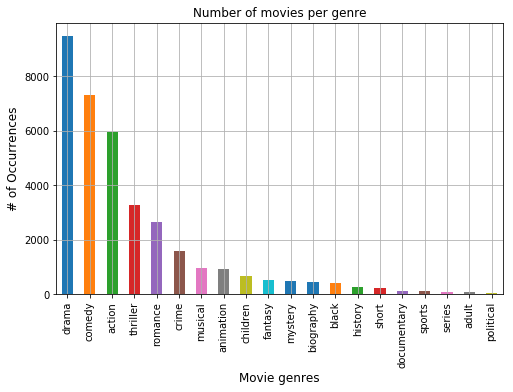

In [24]:
genres[genres['CumulativeFrequency']<=.957][['Genre','Count']].plot(x='Genre', y='Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of movies per genre")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Movie genres', fontsize=12)
plt.show()

In [25]:
mainGenres=np.array(genres[genres['CumulativeFrequency']<=.957]['Genre'])
mainGenres

array(['drama', 'comedy', 'action', 'thriller', 'romance', 'crime',
       'musical', 'animation', 'children', 'fantasy', 'mystery',
       'biography', 'black', 'history', 'short', 'documentary', 'sports',
       'series', 'adult', 'political'], dtype=object)

In [26]:
arr1=np.array(['adult', 'romance', 'drama','and'])
arr1[np.in1d(arr1,mainGenres)] # genres not in the mainGenres array will be deleted


array(['adult', 'romance', 'drama'], dtype='<U7')

In [27]:
df['GenreSplit'][10:12].apply(lambda x: x[np.in1d(x,mainGenres)])

10                   [short]
11    [action, crime, short]
Name: GenreSplit, dtype: object

In [28]:
df['GenreSplitMain'] = df['GenreSplit'].apply(lambda x: x[np.in1d(x,mainGenres)])

In [29]:
df[['GenreSplitMain','GenreSplit','Genre']][200:220]

,GenreSplitMain,GenreSplit,Genre
200,[drama],[drama],drama
201,[drama],[drama],drama
202,[comedy],[comedy],comedy
203,[drama],[drama],drama
204,[comedy],[comedy],comedy
205,"[comedy, drama]","[comedy, drama]",comedy drama
206,[mystery],[mystery],mystery
207,[drama],[drama],drama
208,[drama],[drama],drama
209,"[comedy, drama]","[comedy, drama]",comedy drama


In [30]:
# cleaning plots
# function for cleaning the plots of the movies
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    #text = re.sub('\W', ' ', text)
    #text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [31]:
list(df['Plot'][10:12].apply(clean_text))

['the rarebit fiend gorges on welsh rarebit at a restaurant. when he leaves, he begins to get dizzy as he starts to hallucinate. he desperately tries to hang onto a lamppost as the world spins all around him. a man helps him get home. he falls into bed and begins having more hallucinatory dreams. during a dream sequence, the furniture begins moving around the room. imps emerge from a floating welsh rarebit container and begin poking his head as he sleeps. his bed then begins dancing and spinning wildly around the room before flying out the window with the fiend in it. the bed floats across the city as the fiend floats up and off the bed. he hangs off the back and eventually gets caught on a weathervane atop a steeple. his bedclothes tear and he falls from the sky, crashing through his bedroom ceiling. the fiend awakens from the dream after falling out of his bed.',
 'the film features a train traveling through the rockies and a hold up created by two thugs placing logs on the line. the

In [32]:
df['PlotClean'] = df['Plot'].apply(clean_text)

In [33]:
df[['Plot','PlotClean','GenreSplitMain']][6:12]

,Plot,PlotClean,GenreSplitMain
6,The film opens with two bandits breaking into ...,the film opens with two bandits breaking into ...,[action]
7,The film is about a family who move to the sub...,the film is about a family who move to the sub...,[comedy]
8,The opening scene shows the interior of the ro...,the opening scene shows the interior of the ro...,[]
9,Scenes are introduced using lines of the poem....,scenes are introduced using lines of the poem....,[]
10,The Rarebit Fiend gorges on Welsh rarebit at a...,the rarebit fiend gorges on welsh rarebit at a...,[short]
11,The film features a train traveling through th...,the film features a train traveling through th...,"[action, crime, short]"


In [34]:
len(df['GenreSplitMain'][0])

0

In [35]:
df['GenreSplitMain'][0:5].apply(len)

0    0
1    0
2    0
3    0
4    0
Name: GenreSplitMain, dtype: int64

In [36]:
df['MainGenresCount'] = df['GenreSplitMain'].apply(len)

In [37]:
max(df['MainGenresCount'] )

7

In [38]:
df[df['MainGenresCount']==7]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,Cleaned_genre,GenreSplit,GenreSplitMain,PlotClean,MainGenresCount
17314,2017,American Made,American,Doug Liman,Doug Liman (director); Gary Spinelli (screenpl...,"biography, action, comedy, crime, drama, histo...",https://en.wikipedia.org/wiki/American_Made_(f...,"In the late 1970s, Barry Seal, a pilot for com...",1,biography|action|comedy|crime|drama|history|th...,"[action, biography, comedy, crime, drama, hist...","[action, biography, comedy, crime, drama, hist...","in the late 1970s, barry seal, a pilot for com...",7


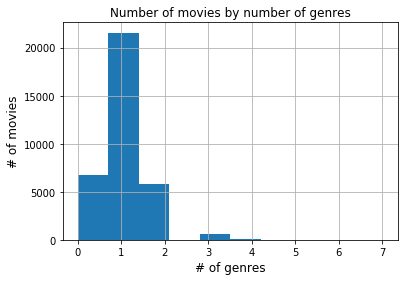

In [39]:
df['MainGenresCount'].hist()

plt.title("Number of movies by number of genres")
plt.ylabel('# of movies', fontsize=12)
plt.xlabel('# of genres', fontsize=12)
plt.show()

### The classifiers 
### Using TF IDF and count vectorizers
### planning on adding DL stuff later on`

In [40]:
df.GenreSplitMain[6:15].apply(lambda x: '-'.join(x)).str.split(pat='-',n=5,expand=True)

,0,1,2
6,action,None,None
7,comedy,None,None
8,,None,None
9,,None,None
10,short,None,None
11,action,crime,short
12,short,None,None
13,biography,None,None
14,comedy,None,None


In [41]:
df.GenreSplitMain[6:15].apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')

,action,biography,comedy,crime,short
6,1,0,0,0,0
7,0,0,1,0,0
8,0,0,0,0,0
9,0,0,0,0,0
10,0,0,0,0,1
11,1,0,0,1,1
12,0,0,0,0,1
13,0,1,0,0,0
14,0,0,1,0,0


In [42]:
df.GenreSplitMain[6:15]

6                   [action]
7                   [comedy]
8                         []
9                         []
10                   [short]
11    [action, crime, short]
12                   [short]
13               [biography]
14                  [comedy]
Name: GenreSplitMain, dtype: object

In [43]:
df.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'Count', 'Cleaned_genre', 'GenreSplit',
       'GenreSplitMain', 'PlotClean', 'MainGenresCount'],
      dtype='object')

# Clasification algos 

In [44]:
# the dummy classes
df = pd.concat([df, df.GenreSplitMain.apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')], axis=1)

In [45]:
# the train and the test data set will be build when there is at least one genre for a movie
MoviesTrain, MoviesTest = train_test_split(df[df.Cleaned_genre!=''], random_state=42, test_size=0.30, shuffle=True)

In [47]:
# definition the algorithm for feature extraction
tfidf = TfidfVectorizer(stop_words ='english', smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')

In [48]:
# building the features
x_train = tfidf.fit_transform(MoviesTrain.PlotClean) 
x_test  = tfidf.transform(MoviesTest.PlotClean)
### for test data, the feature extraction will be done through the function transform()
### to make sure there is no features dimensionality mismatch

In [49]:
print('nrow of the MoviesTrain ={}'. format(MoviesTrain.shape[0]))
print('nrow of the MoviesTest ={}'. format(MoviesTest.shape[0]))

nrow of the MoviesTrain =20077
nrow of the MoviesTest =8605


In [50]:
type(x_train)

scipy.sparse.csr.csr_matrix

In [51]:
x_train.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.91248017, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [52]:
tfidf.inverse_transform(x_train[0].toarray())

[array(['1938', '90', 'able', 'accident', 'accompanies', 'age', 'air',
        'alive', 'allies', 'anytime', 'apartment', 'army', 'asks',
        'asleep', 'away', 'barely', 'basement', 'beating', 'begin',
        'begins', 'believes', 'blast', 'bombed', 'bombing', 'bonfire',
        'book', 'books', 'borrowed', 'borrowing', 'boy', 'boys', 'bring',
        'brother', 'brought', 'burgermeister', 'buried', 'burned',
        'burning', 'camera', 'captivated', 'carries', 'ceremony',
        'chalkboard', 'challenges', 'chant', 'check', 'children',
        'christmas', 'city', 'classmates', 'cold', 'come', 'comes',
        'conscripted', 'cries', 'dangerously', 'day', 'dead', 'death',
        'deutscher', 'dies', 'digger', 'discovers', 'dismisses', 'does',
        'door', 'drive', 'dummkopf', 'dunce', 'east', 'ends', 'enters',
        'escape', 'fail', 'fallen', 'falls', 'family', 'fast', 'father',
        'february', 'fell', 'final', 'finally', 'finish', 'followed',
        'forces', 'forc

In [53]:
print('The corpus is huge. It contain {} words.'.format(len(x_train[0].toarray()[0])))

The corpus is huge. It contain 103134 words.


In [62]:
# building the classes
y_train = MoviesTrain[MoviesTrain.columns[14:]]
y_test = MoviesTest[MoviesTest.columns[14:]]

In [63]:
len(y_test.columns)

20

# Doc2Bow

In [64]:
import pickle
import pandas as pd
import numpy
import re
import os
import numpy as np
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

In [66]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in MoviesTrain['PlotClean'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed:' , j)

Number of texts processed: 20077


In [67]:
d2v_model = Doc2Vec(all_content_train, size = 100, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

/opt/conda/lib/python3.6/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [80]:
# Get the vectors

d2v_model.docvecs[2]

array([-0.17348957, -0.06608305, -0.11404106,  0.29078358,  0.15393025,
       -0.13220522,  0.20646743, -0.21651854,  0.14001031,  0.05341311,
       -0.07820213,  0.15316594,  0.14284141, -0.08029566,  0.00329938,
       -0.18271235, -0.02596433,  0.08125015,  0.03887265,  0.01004593,
        0.28718036,  0.02671846, -0.03858284,  0.02864164,  0.0274421 ,
       -0.20307104,  0.0993892 , -0.06505515,  0.00592096,  0.03967963,
        0.09905638,  0.11948125, -0.04810118,  0.25620893,  0.12293103,
       -0.12264059,  0.11305737,  0.00375808, -0.05670538,  0.00633778,
       -0.06914453,  0.15327188,  0.05221916,  0.12587869, -0.06543235,
        0.0793976 ,  0.04513694,  0.02809124,  0.02728507,  0.05296793,
       -0.02656472,  0.07137781, -0.07595195,  0.11158881,  0.03670857,
       -0.02230198,  0.02043021,  0.01135885,  0.23267028,  0.04185016,
        0.05605173, -0.0470507 , -0.07331676,  0.08080872, -0.03902974,
       -0.03349291, -0.06556281,  0.0957335 ,  0.22433987, -0.07

In [111]:
LabeledSentence2 = gensim.models.doc2vec.TaggedDocument
all_content_train1 = []
j=0
for em in MoviesTest['PlotClean'].values:
    all_content_train1.append(LabeledSentence2(em,[j]))
    j+=1
print('Number of texts processed:' , j)

Number of texts processed: 8605


In [112]:
d2v_model_test = Doc2Vec(all_content_train1, size = 100, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model_test.train(all_content_train1, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [113]:
x_train_doc = d2v_model 
x_test_doc  = d2v_model_test

In [ ]:
#trying out on Multinomial NB


In [110]:
MoviesTrain.PlotClean[7749]
#some random plot 

'a writer named adrian messenger (john merivale) believes a series of apparently unrelated "accidental" deaths are actually linked murders. he asks his friend anthony gethryn (george c. scott), recently retired from mi5, to help clear up the mystery and provides him with a list of the victims\' names. soon afterward, messenger  plane is bombed while he is en route to collect evidence to confirm his suspicions and, with his dying breath, he tries to tell a fellow passenger the key to the mystery.\r\nthe passenger survives and turns out to be raoul le borg (jacques roux), gethryn  old world war ii counterpart in the french resistance. they join forces to investigate messenger  list of names, and decode messenger  final cryptic words. they establish that all on the list were together in a prisoner of war camp in burma, where a canadian sergeant, george brougham, betrayed his fellow prisoners, foiling their escape attempt. each has a reason to kill brougham. it evolves that brougham is the

In [92]:
tokens = MoviesTrain.PlotClean[7749].split()
new_vector = d2v_model.infer_vector(tokens)
docs_similar = d2v_model.docvecs.most_similar([new_vector])

In [93]:
docs_similar # gives top 10 docs and their cosine similarity

[(3650, 0.16198194026947021),
 (5225, 0.0664551705121994),
 (18998, 0.05804510787129402),
 (6488, 0.030819818377494812),
 (4774, 0.029581621289253235),
 (207, 0.02953772433102131),
 (3970, 0.020368121564388275),
 (5716, 0.01596100628376007),
 (2410, 0.013005495071411133),
 (2501, 0.006253331899642944)]

In [115]:
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
multinomialNB=OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

In [116]:
y_train_doc = MoviesTrain[MoviesTrain.columns[14:]]
y_test_doc = MoviesTest[MoviesTest.columns[14:]]

In [118]:
accuracy_multinomialNB=pd.DataFrame(columns=['Genre', 'accuracy_multinomialNB'])
accuracy_multinomialNB.head()

,Genre,accuracy_multinomialNB


In [122]:
i = 0
for genre in mainGenres:
    multinomialNB.fit(x_train_doc.reshape(-1, 1), y_train_doc[genre])
    prediction1 = multinomialNB.predict(x_test_doc.reshape(-1, 1))
    accuracy_multinomialNB.loc[i,'Genre'] = genre
    accuracy_multinomialNB.loc[i,'accuracy_multinomialNB'] = accuracy_score(y_test_doc[genre], prediction1)
    i=i+1
    

    
accuracy_multinomialNB

AttributeError: 'Doc2Vec' object has no attribute 'reshape'

#  multinomial Naive Bayes Classification

In [ ]:
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
multinomialNB=OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

In [ ]:

# fitting
multinomialNB.fit(x_train, y_train.action)

In [ ]:
# compute the testing accuracy
prediction = multinomialNB.predict(x_test)


In [ ]:
print('Test accuracy is {}'.format(accuracy_score(y_test.action, prediction)))


In [ ]:
len(mainGenres)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('F1 score is {}'.format(f1_score(y_test.action, prediction,average='micro')))


# multinomial Naive Bayes Classification for all the movie genres

In [ ]:
accuracy_multinomialNB=pd.DataFrame(columns=['Genre', 'accuracy_multinomialNB'])
accuracy_multinomialNB.head()

In [ ]:
i = 0
for genre in mainGenres:
    multinomialNB.fit(x_train, y_train[genre])
    prediction = multinomialNB.predict(x_test)
    accuracy_multinomialNB.loc[i,'Genre'] = genre
    accuracy_multinomialNB.loc[i,'accuracy_multinomialNB'] = accuracy_score(y_test[genre], prediction)
    i=i+1
    

    
accuracy_multinomialNB

# Linear Support Vector Classification for all the movie genres



In [ ]:
linearSVC=OneVsRestClassifier(LinearSVC(), n_jobs=1)


In [ ]:
accuracy_LinearSVC=pd.DataFrame(columns=['Genre', 'accuracy_LinearSVC'])
accuracy_LinearSVC.head()

In [ ]:
i = 0
for genre in mainGenres:
    linearSVC.fit(x_train, y_train[genre])
    prediction = linearSVC.predict(x_test)
    accuracy_LinearSVC.loc[i,'Genre'] = genre
    accuracy_LinearSVC.loc[i,'accuracy_LinearSVC'] = accuracy_score(y_test[genre], prediction)
    i=i+1

In [ ]:
accuracy_LinearSVC

In [ ]:
# merging the accuracy tables
accuracy_svc_mnb = pd.merge(accuracy_multinomialNB, accuracy_LinearSVC, on='Genre', how='inner')

In [ ]:
accuracy_svc_mnb

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('F1 score is {}'.format(f1_score(y_test.action, prediction,average='micro')))